In [1]:
from sklearn.model_selection import train_test_split
from experiment import tune_architecture, tune_hyperparameters, plot_confusion_matrices, plot_roc_curves, plot_losses
from model import predict
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import torch
import preprocessing
import numpy as np

# Data preprocessing

In [2]:
df = pd.read_csv("train_data.csv")
df.head()

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0


## Check for duplicated rows

In [3]:
df.duplicated().sum()
df = df.drop_duplicates()

## Assign labels

In [4]:
df["Label"] = df["SalePrice"].apply(preprocessing.classify)
df = df.drop(columns=["SalePrice"])
df.head()

,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total),Label
0,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0,1
1,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
2,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0,0
3,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0,2
4,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0,0


## Check for missing values

In [5]:
preprocessing.missing(df, df.columns)

{}

# Categorical data

In [6]:
numeric_columns = df._get_numeric_data().columns
categorical_columns = list(set(df.columns) - set(numeric_columns))
numeric_columns = list(set(numeric_columns) - {'Label'})

In [7]:
categorical_unique = preprocessing.unique(df, categorical_columns)
numeric_unique = preprocessing.unique(df, numeric_columns)

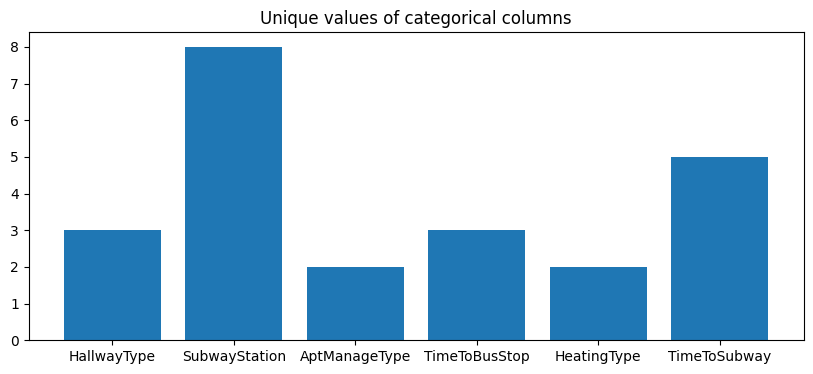

In [8]:
preprocessing.plot_bar(categorical_unique, "Unique values of categorical columns")

In [9]:
counts_by_label = dict(df["Label"].value_counts())
label_assignment = {0: "cheap (0)", 1:"average (1)", 2:"expensive (2)"}
counts_by_label = {label_assignment[key]: val for key, val in counts_by_label.items()}

We split categorical columns on nominal and ordinal to leverage the natural order of ordinal features.

In [10]:
ordinal_columns = ["TimeToBusStop", "TimeToSubway"]
nominal_columns = list(set(categorical_columns) - set(ordinal_columns))

## Check for outliers 

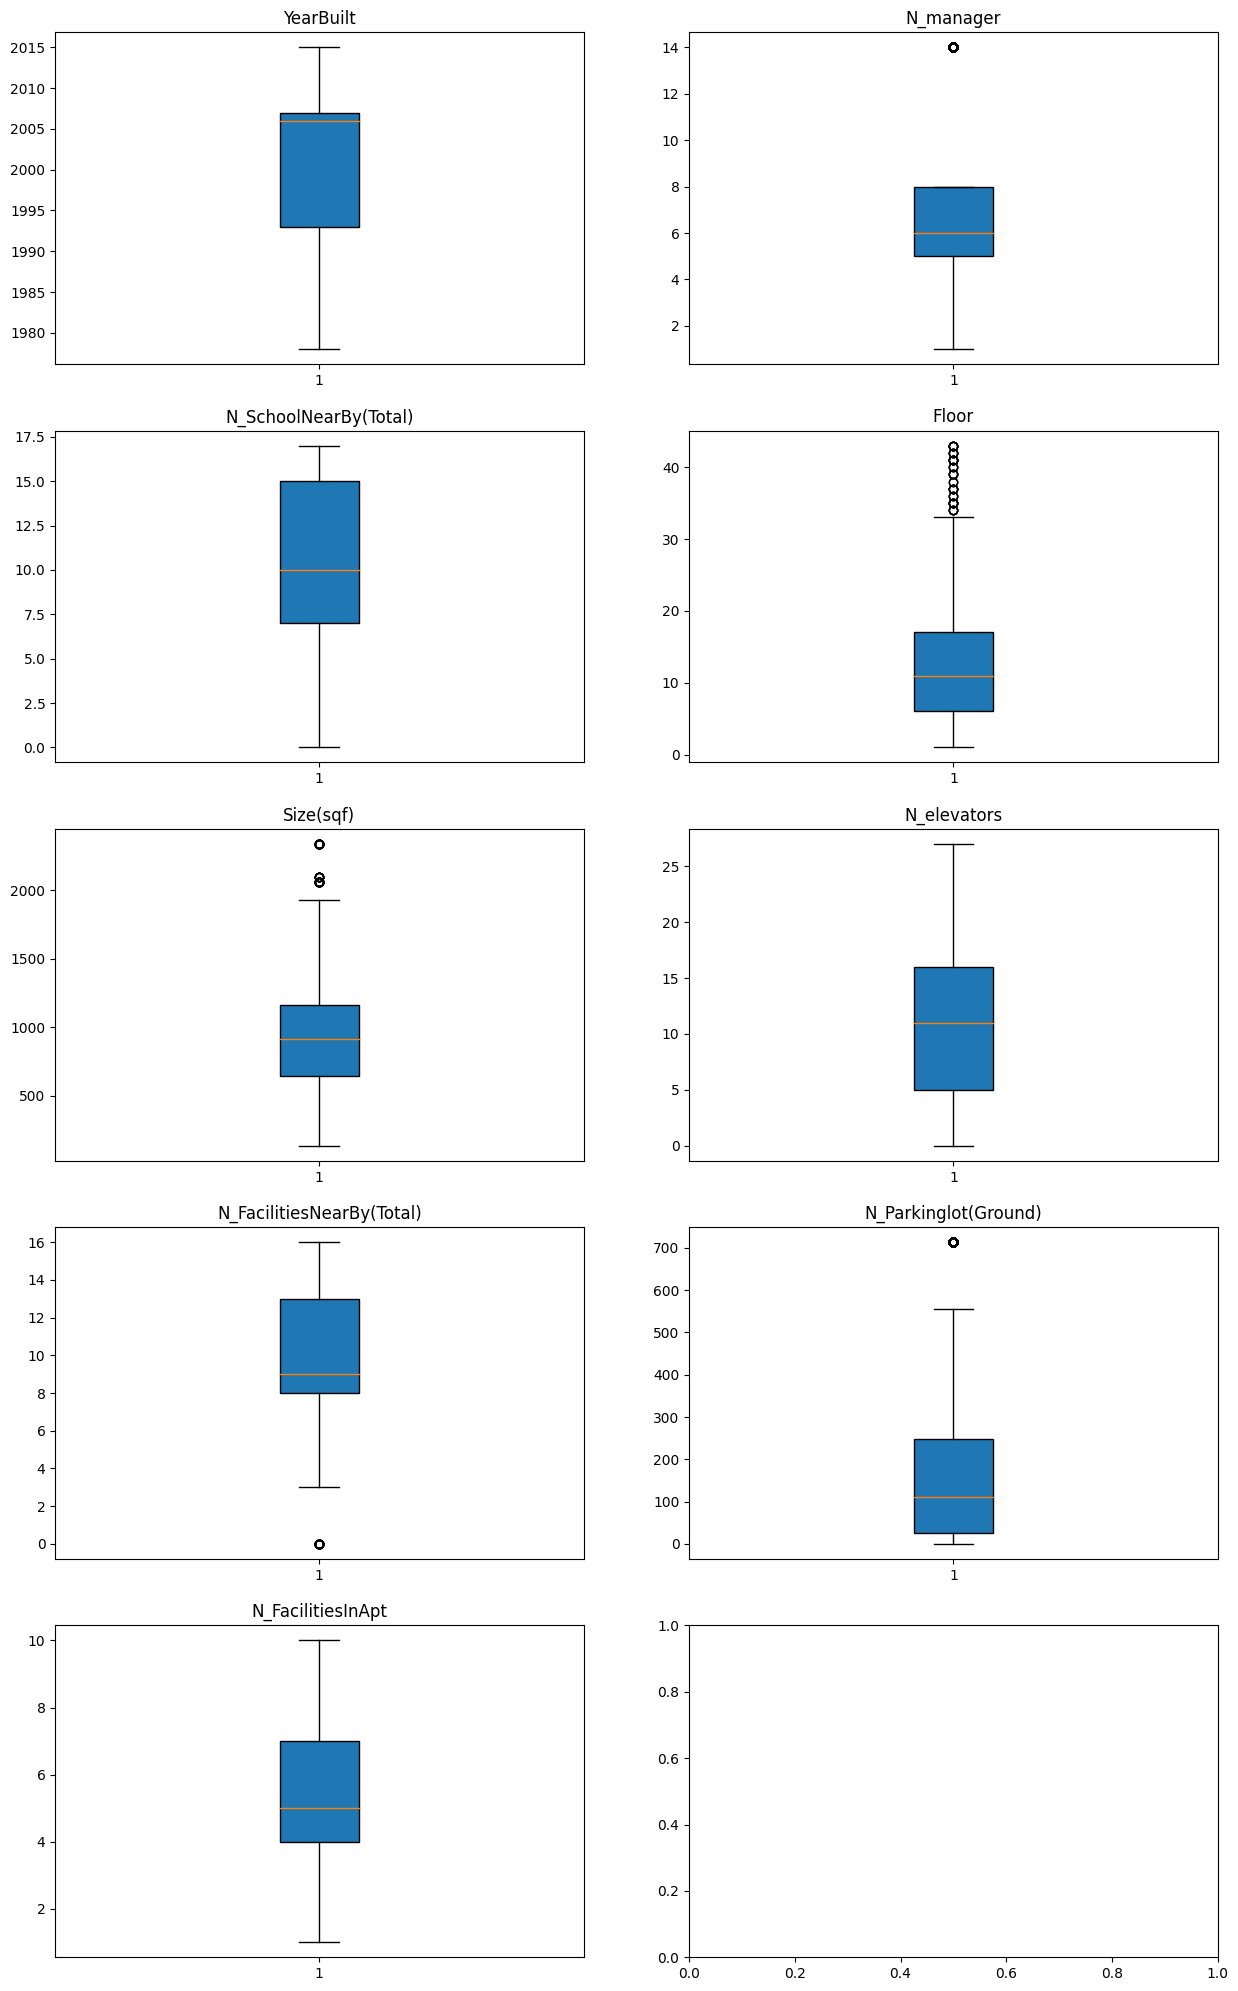

In [11]:
preprocessing.plot_boxplot(df, numeric_columns)

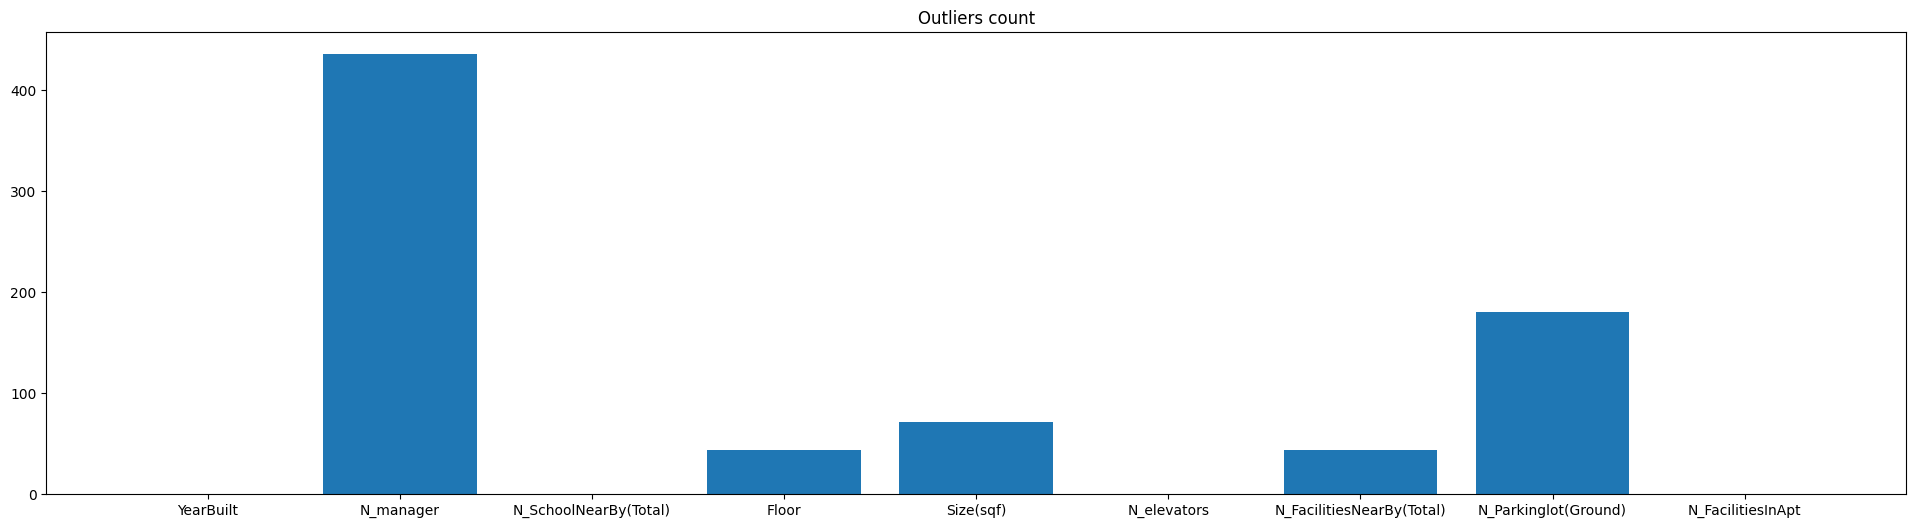

In [12]:
outliers_counts, outliers = preprocessing.check_outliers(df, numeric_columns)
preprocessing.plot_bar(outliers_counts, "Outliers count", size=(24, 6))

Since we don't have much data and the outliers are not too extreme we've decided to let them be.

## Analyze if some features have normal distribution
We analyze the distribution of the features to decide how to normalize the data.

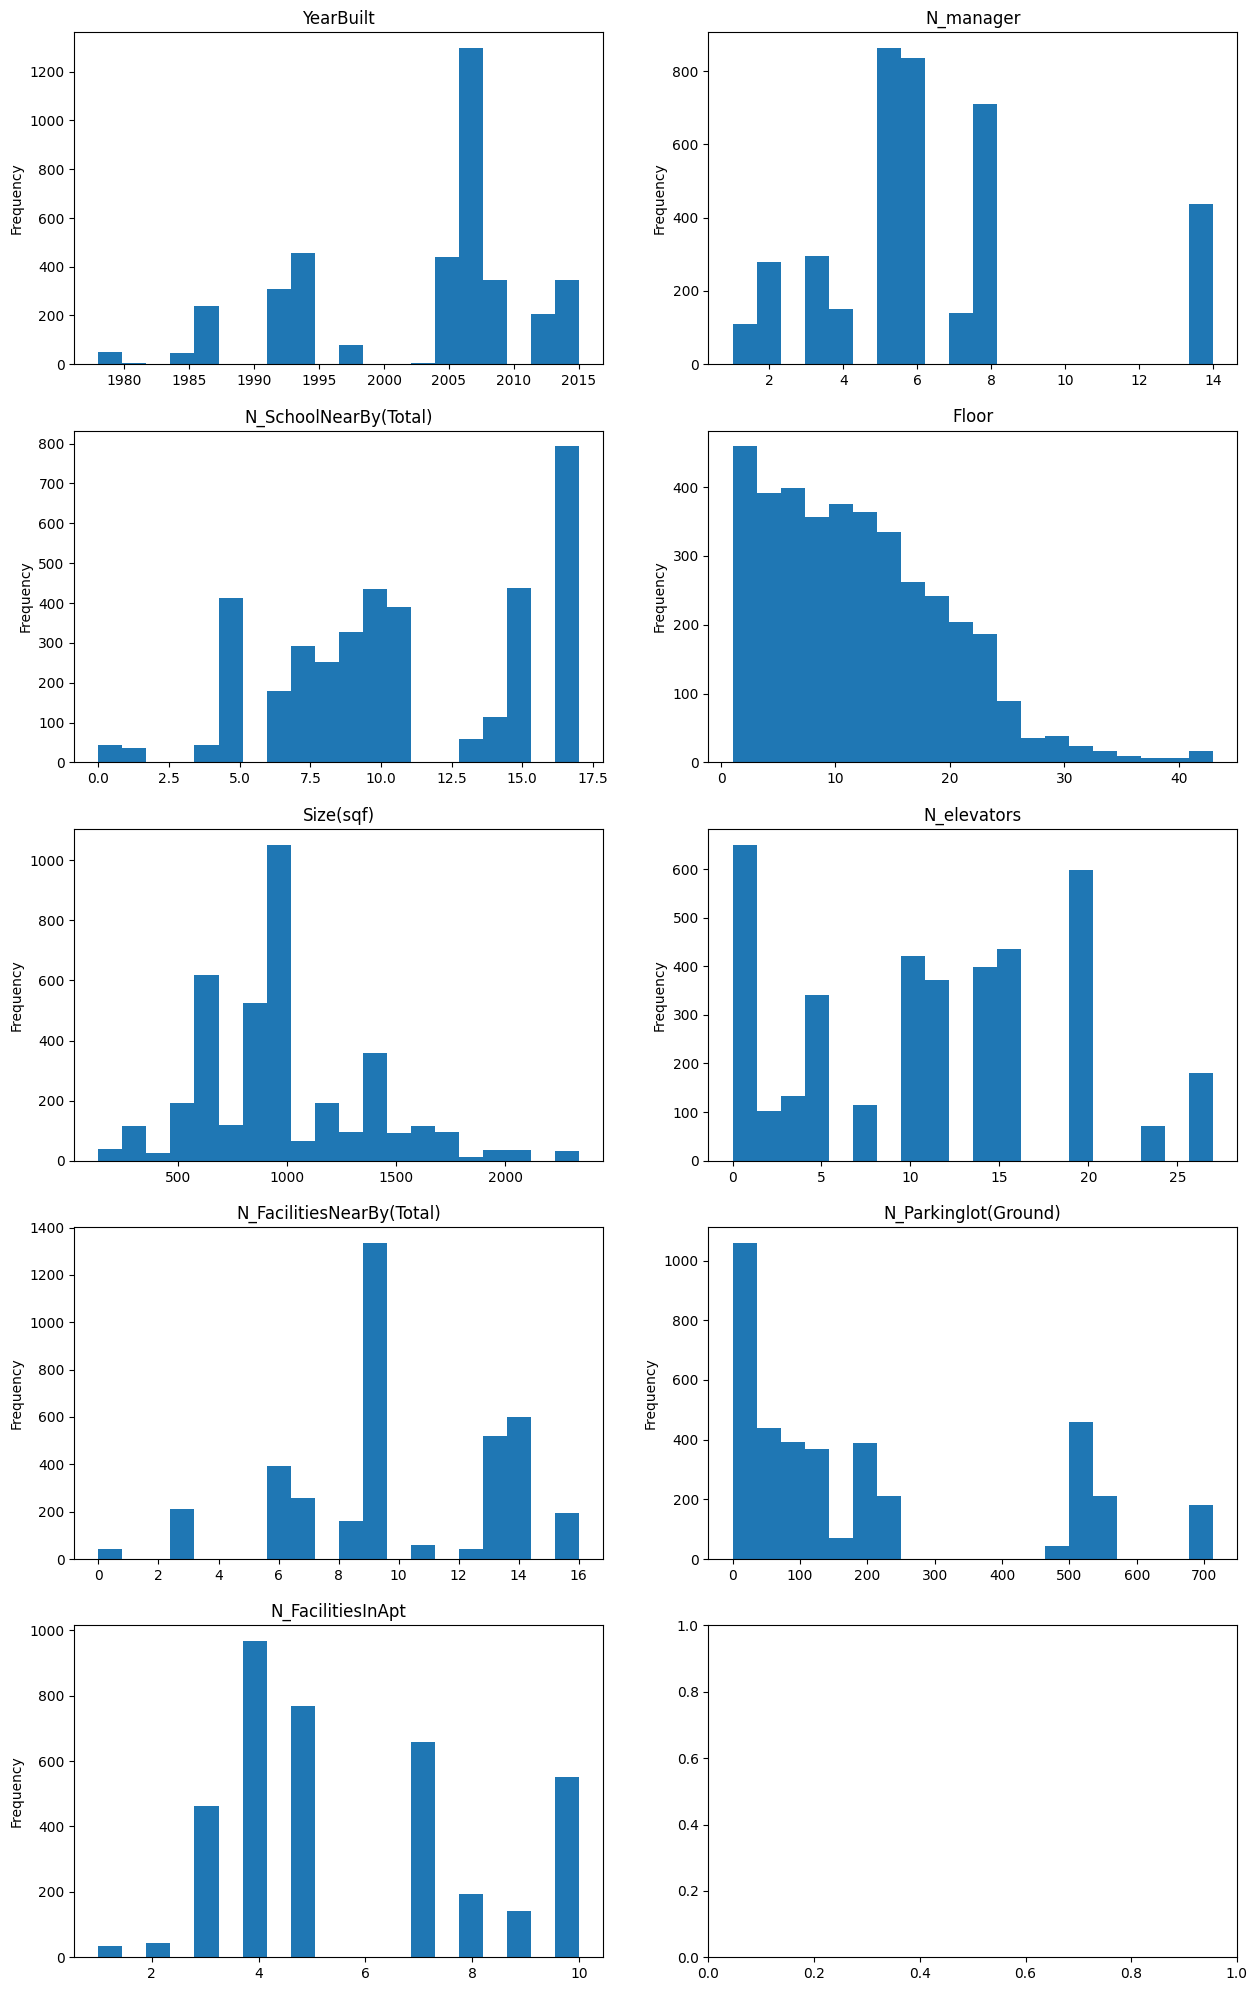

In [13]:
preprocessing.plot_histograms(df, numeric_columns)

In [14]:
preprocessing.shapiro_wilk(df, numeric_columns)

{'YearBuilt': 'not normally distributed',
 'N_manager': 'not normally distributed',
 'N_SchoolNearBy(Total)': 'not normally distributed',
 'Floor': 'not normally distributed',
 'Size(sqf)': 'not normally distributed',
 'N_elevators': 'not normally distributed',
 'N_FacilitiesNearBy(Total)': 'not normally distributed',
 'N_Parkinglot(Ground)': 'not normally distributed',
 'N_FacilitiesInApt': 'not normally distributed'}

## Categorical features distribution

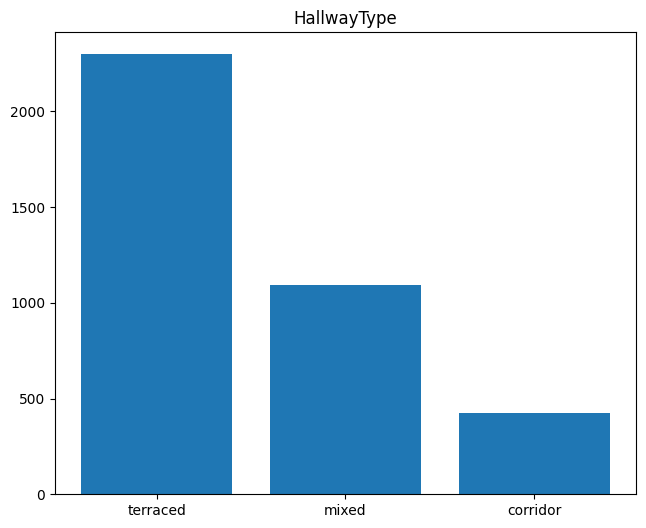

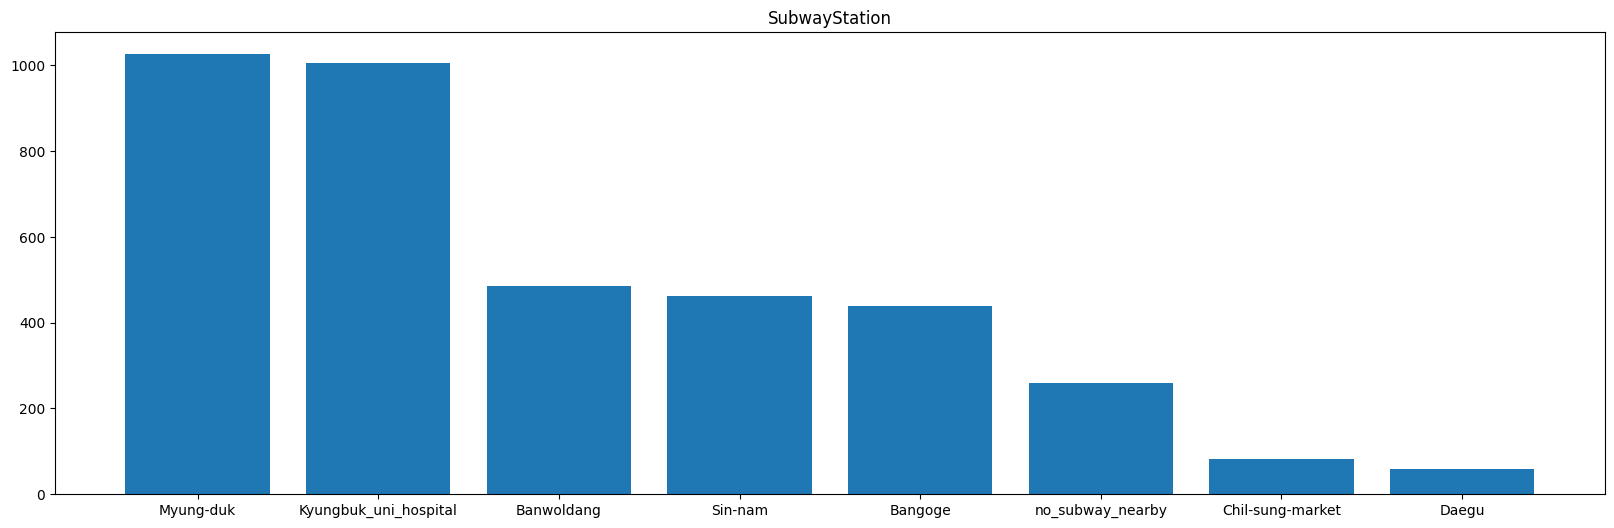

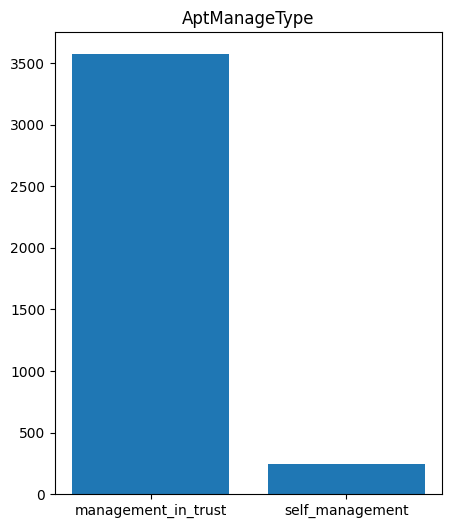

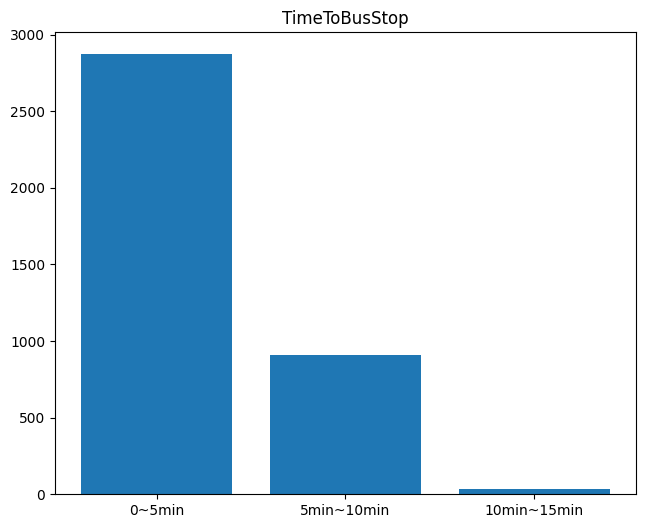

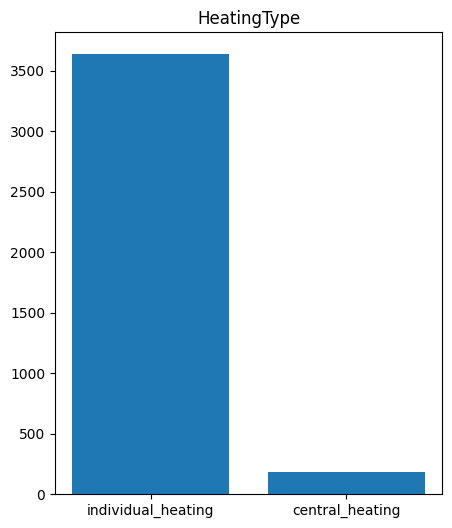

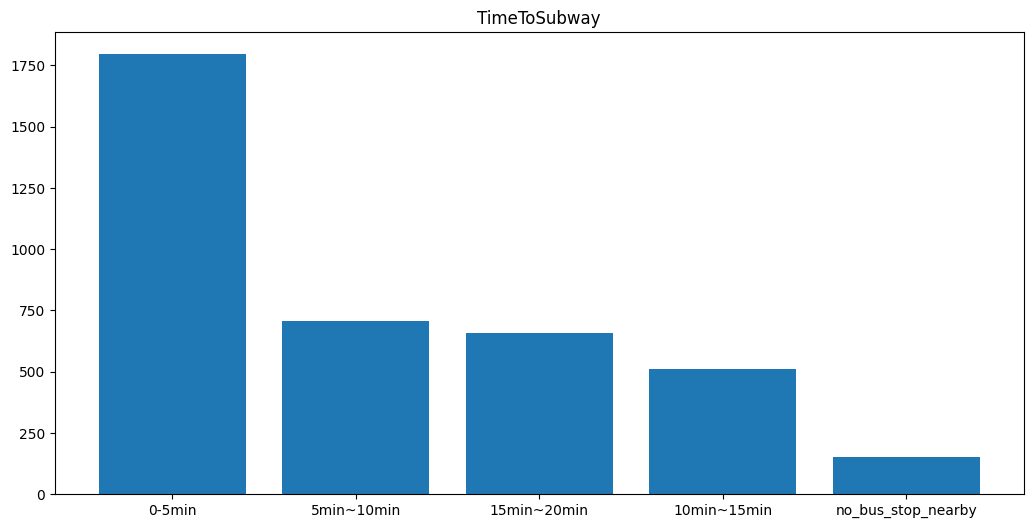

In [15]:
for col in categorical_columns:
    preprocessing.plot_bar(df[col].value_counts(), col, size=(2.5*len(df[col].value_counts()), 6))

## Analyzing the data imbalance

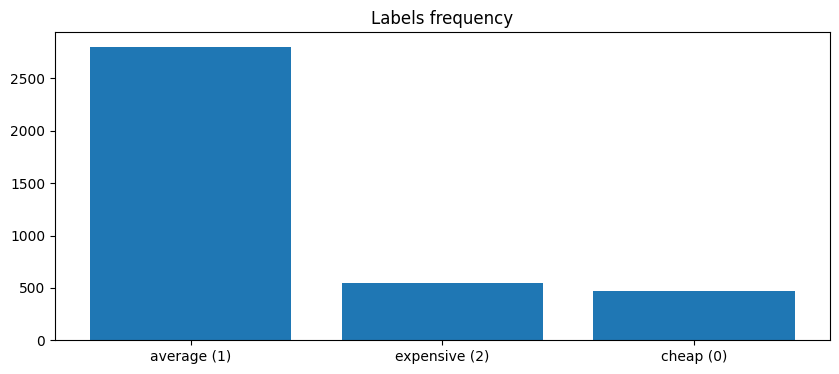

In [16]:
preprocessing.plot_bar(counts_by_label, "Labels frequency")

We can see that data is heavily imbalanced, with class 'average'(1) dominating the set.

In [17]:
weights = preprocessing.calculate_class_weights(df["Label"])
weights

tensor([2.6899, 0.4542, 2.3432])

## Final preprocessing
For preprocessing we:
- convert nominal features to one-hot vectors
- convert ordinal features to ordinal encoding, while keeping the correct order (0-5min: 0, 5-10min: 1 etc.)
- scale the numeric features using min-max scaler; we chose this normalization because none of the features have normal distribution

## Choosing the data imbalance handling
We experiment with four approaches of handling the data imbalance:
- oversampling the minority classes
- undersampling the majority class
- using weighted cross-entropy loss
- leaving the dataset without changes

To distinguish which approach performs the best we use (and continue to use in further experiments) these metrics:
- accuracy
- precision
- recall
- f1 score

Since we want to get the best performance **per-class** we focus on recall to choose the best performing model.
The data is split into training and validation sets in 4:1 ratio. Each metric is measured both for training set and validation set.

Additionally we print classification report for each model which shows values of above metrics **per-class**.

In [18]:
X = df.drop(columns=["Label"])
y = df["Label"]
train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.2)
oversample_train_x, oversample_train_y = preprocessing.preprocess(
    train_x,
    numeric_columns,
    ordinal_columns,
    nominal_columns,
    y=train_y,
    oversample=True,
    undersample=False,
    random_state=42,
    echo_ordinal_counts=False,
)
undersample_train_x, undersample_train_y = preprocessing.preprocess(
    train_x,
    numeric_columns,
    ordinal_columns,
    nominal_columns,
    y=train_y,
    oversample=False,
    undersample=True,
    random_state=42,
    echo_ordinal_counts=False,
)
oversample_undersample_train_x, oversample_undersample_train_y = preprocessing.preprocess(
    train_x,
    numeric_columns,
    ordinal_columns,
    nominal_columns,
    y=train_y,
    oversample=True,
    undersample=True,
    random_state=42,
    echo_ordinal_counts=False,
)
nosample_train_x, nosample_train_y = preprocessing.preprocess(
    train_x,
    numeric_columns,
    ordinal_columns,
    nominal_columns,
    y=train_y,
    oversample=False,
    undersample=False,
    random_state=42,
    echo_ordinal_counts=False,
)
val_x, val_y = preprocessing.preprocess(
    val_x,
    numeric_columns,
    ordinal_columns,
    nominal_columns,
    y=val_y,
    oversample=False,
    undersample=False,
    random_state=42,
)
test_architecture = [[
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ]]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_setup_no_weights = {"epochs": 80, "lr": 3e-4, "batch_size": 64, "class_weights": None}
training_setup_weights = {"epochs": 80, "lr": 3e-4, "batch_size": 64, "class_weights": weights}
losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_architecture(oversample_train_x, oversample_train_y, val_x, val_y, test_architecture, training_setup_no_weights, device)
oversampling_results = pd.DataFrame({"data correction": ["oversampling"], "balanced train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "balanced val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_architecture(undersample_train_x, undersample_train_y, val_x, val_y, test_architecture, training_setup_no_weights, device)
undersampling_results = pd.DataFrame({"data correction": ["undersampling"], "balanced train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "balanced val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_architecture(nosample_train_x, nosample_train_y, val_x, val_y, test_architecture, training_setup_weights, device)
no_sampling_weights_results = pd.DataFrame({"data correction": ["no sampling + weights"], "balanced train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "balanced val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_architecture(nosample_train_x, nosample_train_y, val_x, val_y, test_architecture, training_setup_no_weights, device)
no_sampling_results = pd.DataFrame({"data correction": ["no sampling"], "balanced train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "balanced val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})

Training model 0
Training done
              precision    recall  f1-score   support

           0       0.52      0.99      0.68        78
           1       0.98      0.78      0.87       560
           2       0.69      0.94      0.79       126

    accuracy                           0.82       764
   macro avg       0.73      0.90      0.78       764
weighted avg       0.88      0.82      0.84       764

Training model 0
Training done
              precision    recall  f1-score   support

           0       0.50      0.99      0.67        78
           1       0.98      0.76      0.86       560
           2       0.67      0.93      0.78       126

    accuracy                           0.81       764
   macro avg       0.72      0.89      0.77       764
weighted avg       0.88      0.81      0.82       764

Training model 0
Training done
              precision    recall  f1-score   support

           0       0.52      0.99      0.68        78
           1       0.98      0.78   

In [19]:
pd.concat([oversampling_results, undersampling_results, no_sampling_weights_results, no_sampling_results], ignore_index=True)

,data correction,balanced train accuracy,train precision,train recall,train f1,balanced val accuracy,val precision,val recall,val f1
0,oversampling,0.889781,0.891614,0.889781,0.886409,0.824607,0.728682,0.900158,0.779965
1,undersampling,0.881857,0.882440,0.881857,0.878489,0.812827,0.717599,0.892750,0.767745
2,no sampling + weights,0.799541,0.709746,0.889968,0.760768,0.824607,0.728540,0.900158,0.780092
3,no sampling,0.873895,0.838343,0.771182,0.798855,0.873037,0.835033,0.754848,0.789070


All of the data imbalance handling methods have much higher recall than unmodified dataset. Oversampling and loss weighting perform the best, we will choose oversampling for further experiments.

In [20]:
train_x, train_y = oversample_train_x, oversample_train_y

# Model and training
We experiment with different models to choose the correct architecture. Since accuracy metric for imbalanced tasks may be misleading we also introduce precision, recall, f1 score and ROC curve. The best model is chosen based on f1 score. For fair comparison each architecture is trained with the same hyperparameters.
We test models with different layer sizes, and depth. We use batch normalization for each architecture, since it almost always improves performance. All of the models use ReLU activation function. Influence of dropout is also tested.

In [21]:
architectures = [
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"linear": (128, 64), "batch_norm": 64, "activation": True},
        {"linear": (64, 32), "batch_norm": 32, "activation": True},
        {"linear": (32, 3)}
    ],
    [
        {"linear": (27, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 3)}
    ],
    [
        {"linear": (27, 128), "batch_norm": 128, "activation": True},
        {"dropout": 0.3, "linear": (128, 64), "batch_norm": 64, "activation": True},
        {"dropout": 0.3, "linear": (64, 32), "batch_norm": 32, "activation": True},
        {"dropout": 0.3, "linear": (32, 3)}
    ],
]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
training_setup = {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None}
losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_architecture(train_x, train_y, val_x, val_y, architectures, training_setup, device)

Training model 0
Training done
              precision    recall  f1-score   support

           0       0.52      0.99      0.68        78
           1       0.98      0.79      0.87       560
           2       0.71      0.94      0.81       126

    accuracy                           0.83       764
   macro avg       0.74      0.90      0.79       764
weighted avg       0.89      0.83      0.84       764

Training model 1
Training done
              precision    recall  f1-score   support

           0       0.52      0.99      0.68        78
           1       0.98      0.78      0.87       560
           2       0.69      0.95      0.80       126

    accuracy                           0.83       764
   macro avg       0.73      0.91      0.78       764
weighted avg       0.89      0.83      0.84       764

Training model 2
Training done
              precision    recall  f1-score   support

           0       0.53      0.96      0.68        78
           1       0.98      0.79   

In [24]:
architecture_results = pd.DataFrame({"models": architectures, "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
architecture_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.892607,0.894085,0.892607,0.889570,0.832461,0.736799,0.903729,0.787724
1,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.892161,0.893856,0.892161,0.889005,0.827225,0.731363,0.905449,0.783226
2,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.891269,0.891754,0.891269,0.888715,0.832461,0.735238,0.902523,0.787167
3,"[{'linear': (27, 64), 'batch_norm': 64, 'activ...",0.884278,0.885813,0.884278,0.880695,0.811518,0.716399,0.894205,0.766892
4,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.887996,0.889712,0.887996,0.884611,0.815445,0.720278,0.895991,0.770636
5,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.883683,0.884772,0.883683,0.880250,0.815445,0.720240,0.893941,0.770253


Architecture number 1 achieved the highest recall result. We continue tuning the model with this architecture.

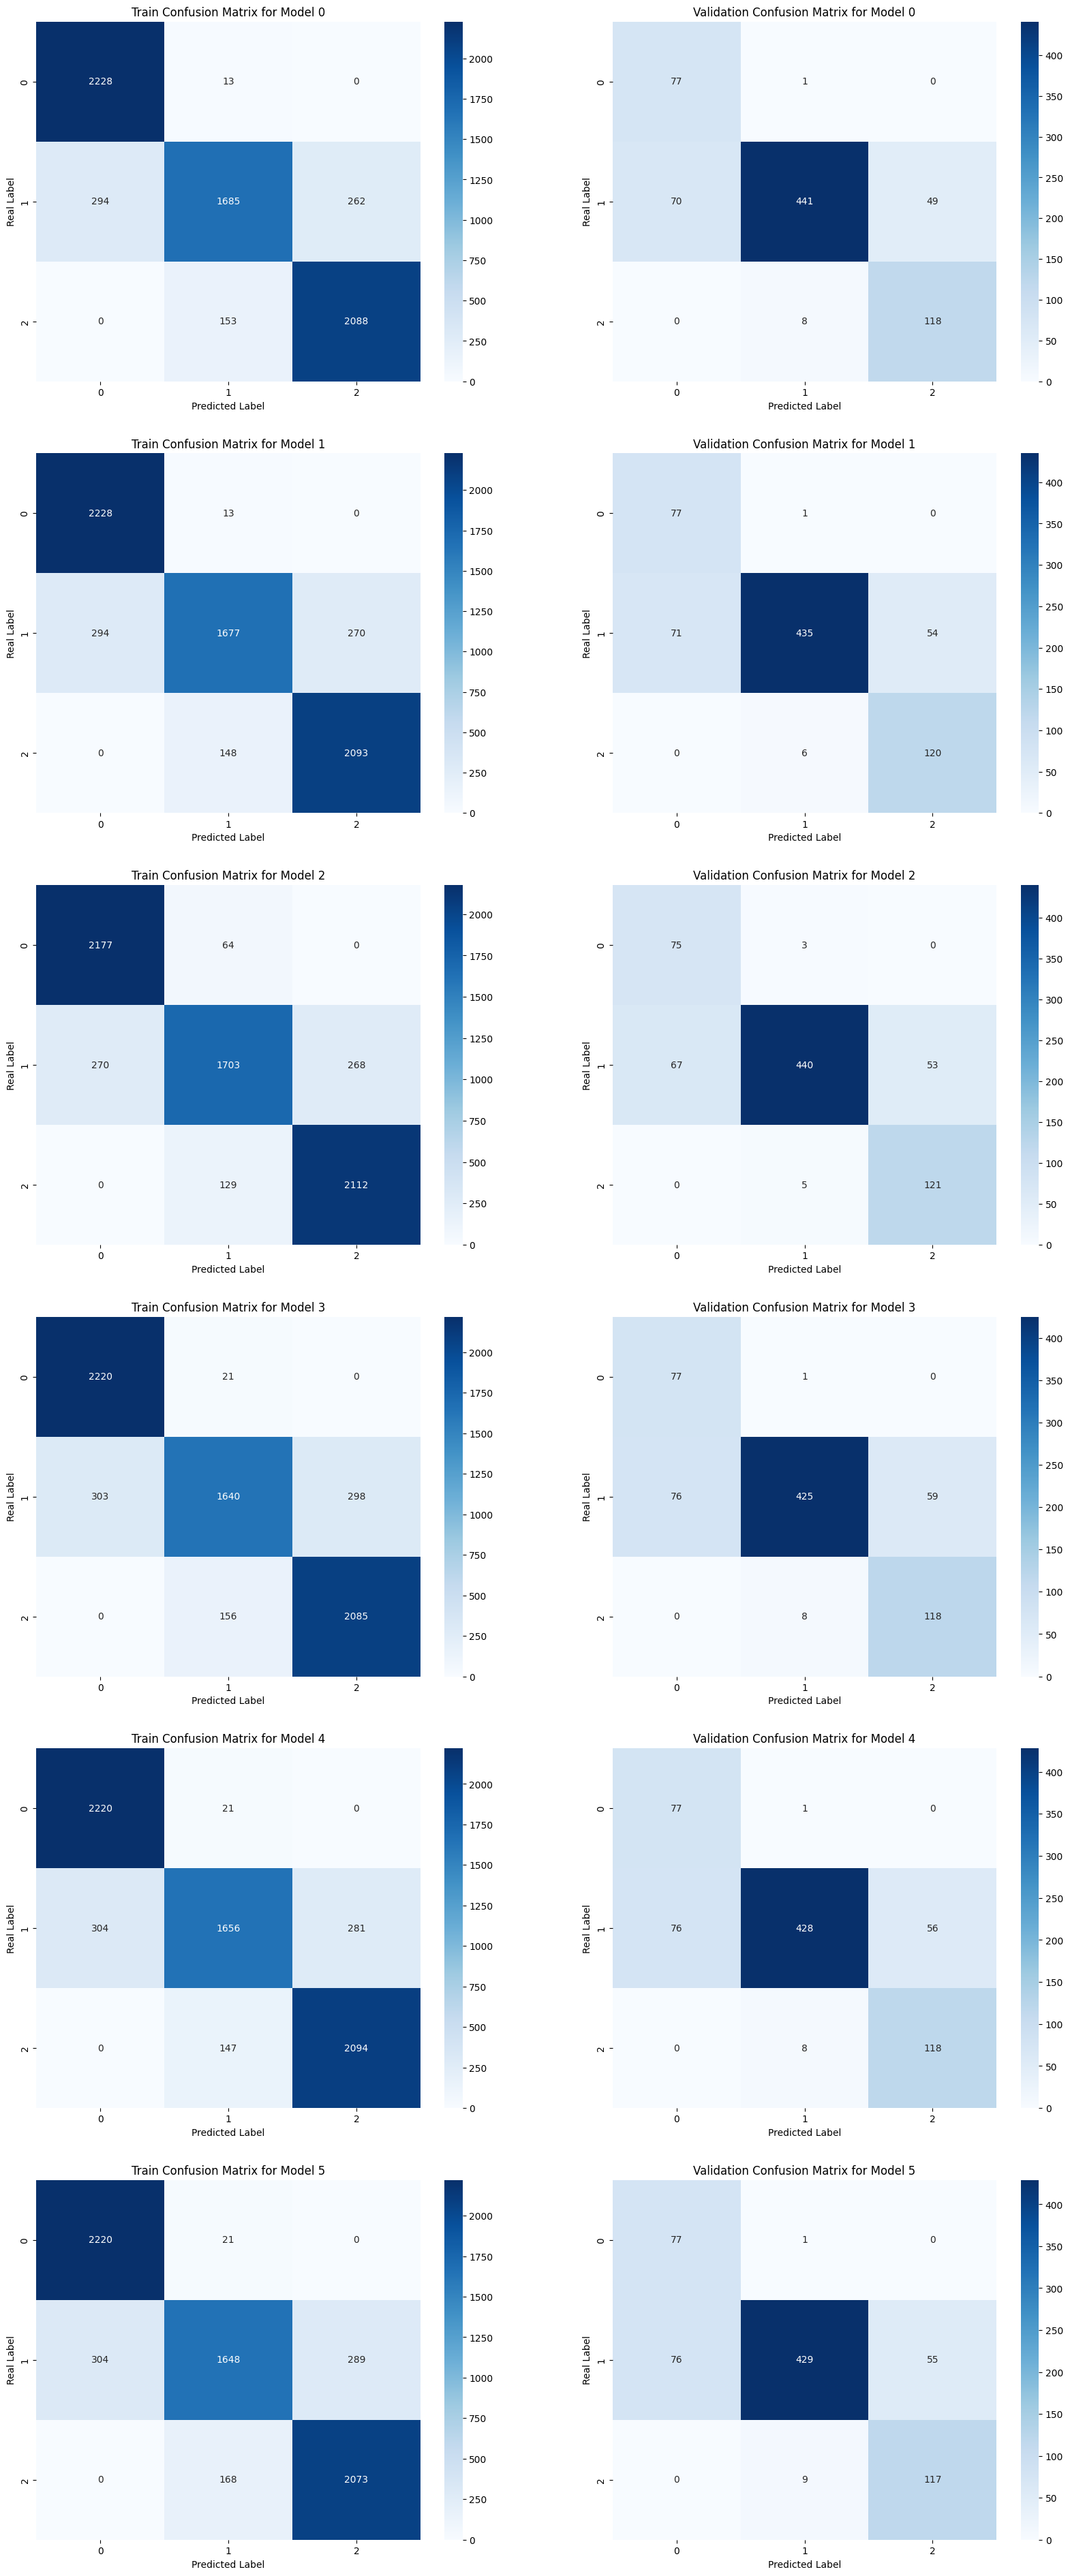

In [25]:
plot_confusion_matrices(train_confusion_matrix, val_confusion_matrix)

On confusion matrices we can see that the model is generalizing well to minority labels.

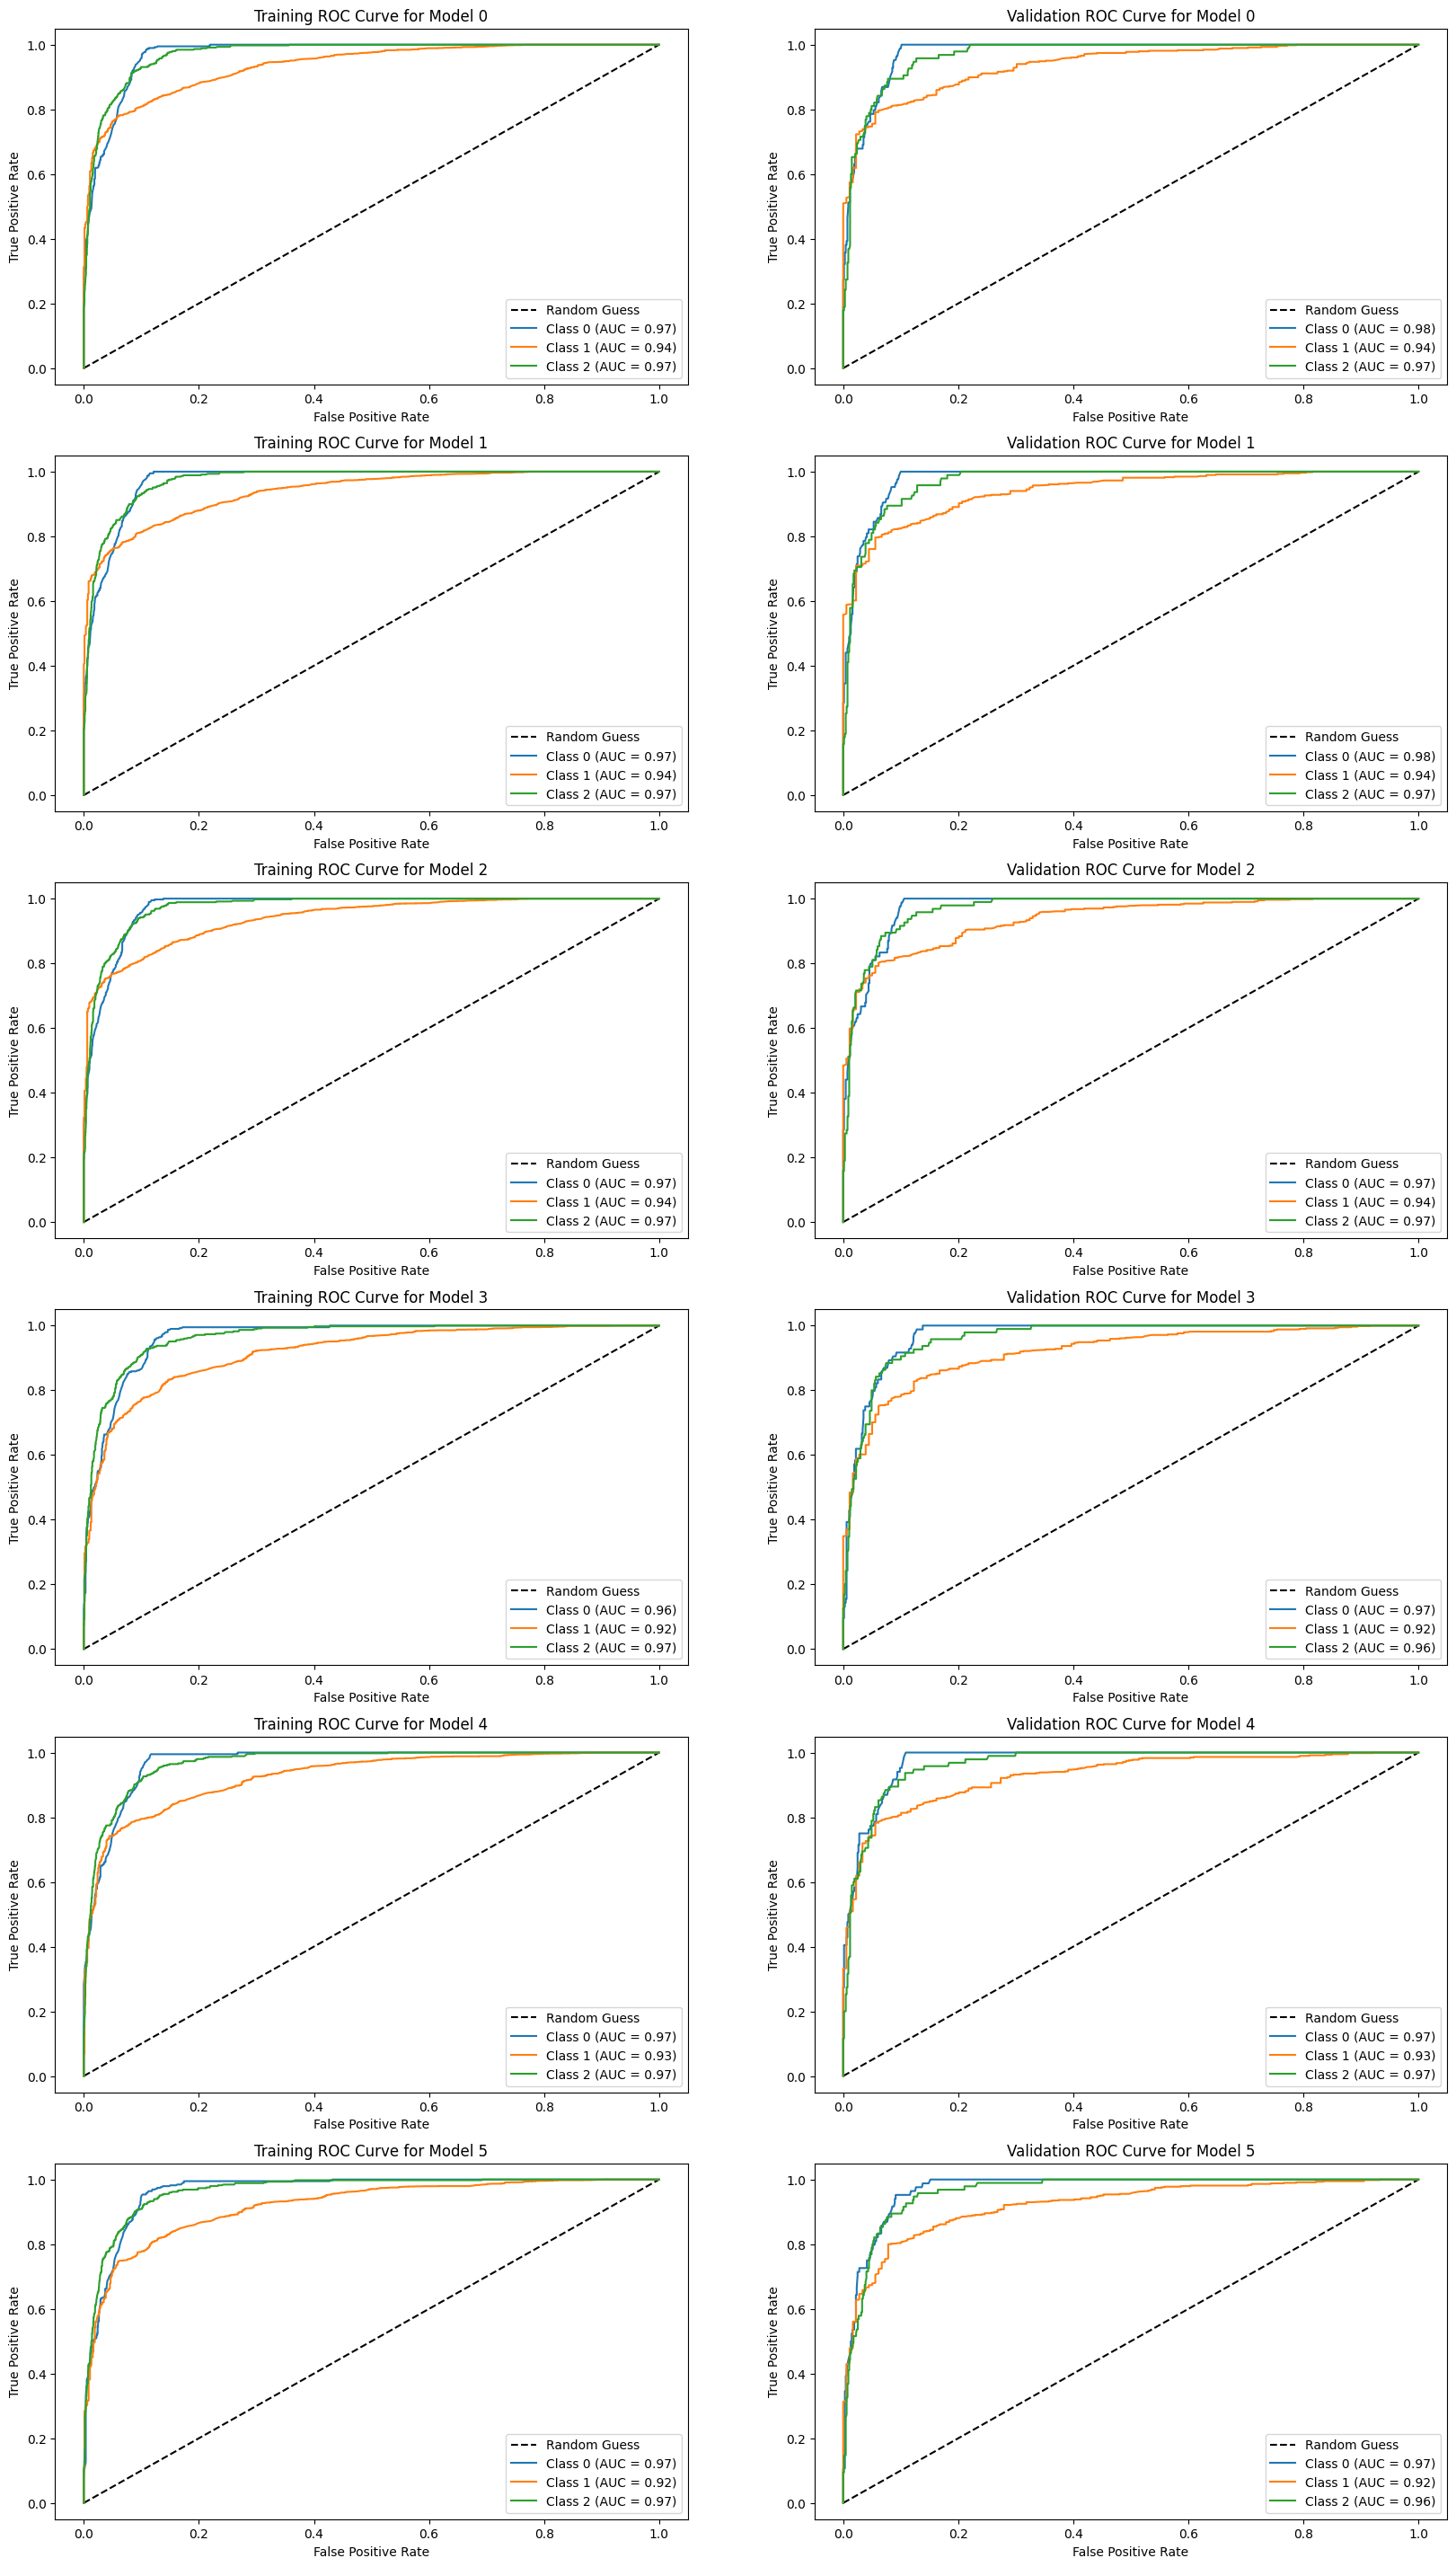

In [25]:
plot_roc_curves(train_roc_curve, val_roc_curve)

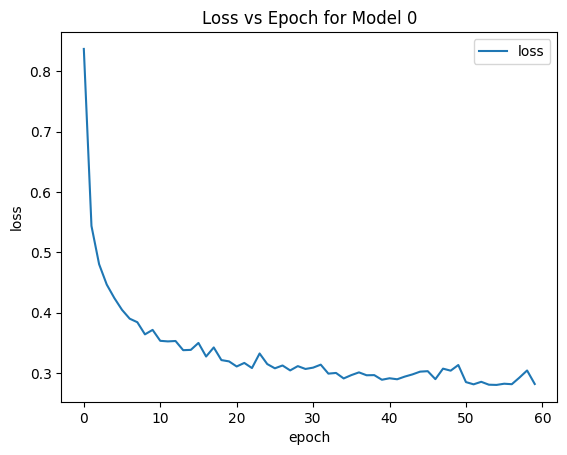

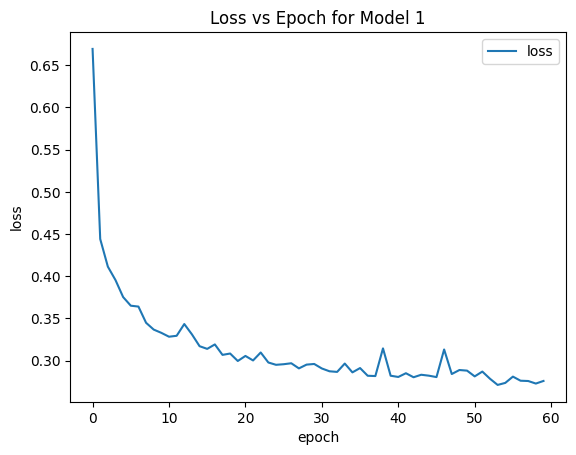

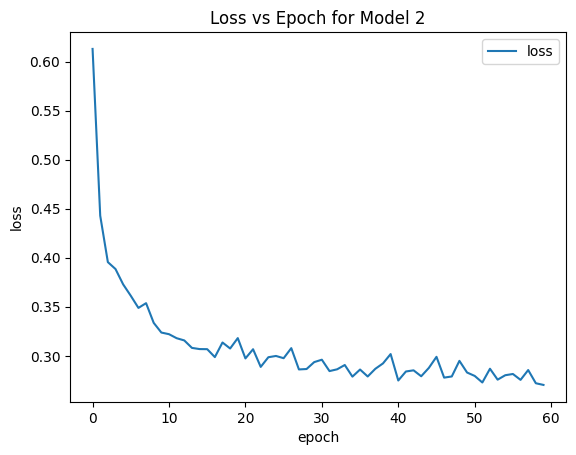

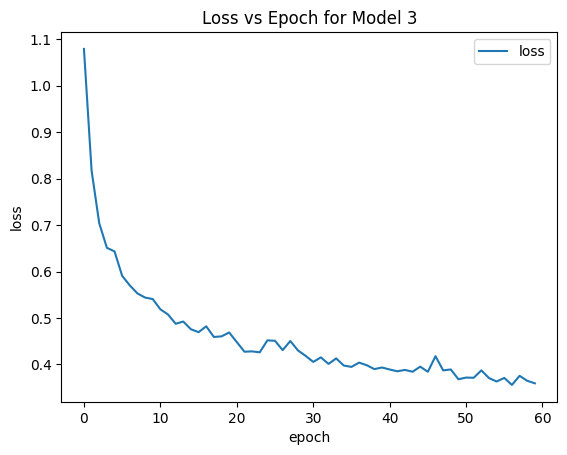

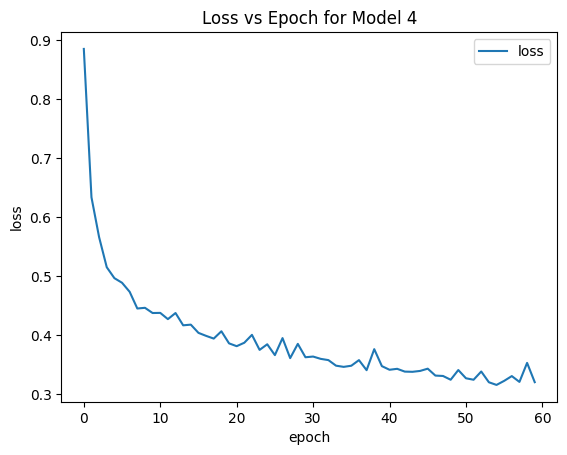

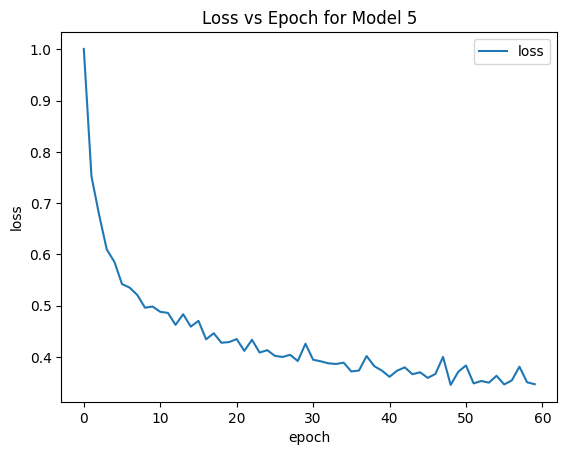

In [26]:
plot_losses(losses)

All architectures had rather standard learning curve, with some fluctuations.

## Hyperparameter tuning
We then take the best performing architecture, train it with different hyperparameters and once again choose the best one based on recall.

In [27]:
hyperparameters = [
    {"epochs": 60, "lr": 3e-2, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-2, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-3, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-4, "batch_size": 128, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 64, "class_weights": None},
    {"epochs": 60, "lr": 3e-5, "batch_size": 128, "class_weights": None},
    ]
final_model, losses, train_accuracy, train_precision, train_recall, train_f1, train_confusion_matrix, train_roc_curve, val_accuracy, val_precision, val_recall, val_f1, val_confusion_matrix, val_roc_curve = tune_hyperparameters(train_x, train_y, val_x, val_y, architectures[1], hyperparameters, device)

Training model 0
Training done
              precision    recall  f1-score   support

           0       0.52      0.99      0.68        78
           1       0.98      0.74      0.85       560
           2       0.63      0.95      0.76       126

    accuracy                           0.80       764
   macro avg       0.71      0.89      0.76       764
weighted avg       0.88      0.80      0.82       764

Training model 1
Training done
              precision    recall  f1-score   support

           0       0.51      1.00      0.67        78
           1       0.98      0.77      0.86       560
           2       0.68      0.91      0.78       126

    accuracy                           0.82       764
   macro avg       0.72      0.89      0.77       764
weighted avg       0.88      0.82      0.83       764

Training model 2
Training done
              precision    recall  f1-score   support

           0       0.52      1.00      0.69        78
           1       0.99      0.75   

In [28]:
hyperparameters_results = pd.DataFrame({"models": [architectures[1]]*len(hyperparameters), "train accuracy": train_accuracy, "train precision": train_precision, "train recall": train_recall, "train f1": train_f1, "val accuracy": val_accuracy, "val precision": val_precision, "val recall": val_recall, "val f1": val_f1})
hyperparameters_results

,models,train accuracy,train precision,train recall,train f1,val accuracy,val precision,val recall,val f1
0,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.892310,0.896103,0.892310,0.888467,0.803665,0.709514,0.894734,0.761024
1,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.894839,0.896033,0.894839,0.892086,0.816754,0.722043,0.894114,0.771669
2,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.893649,0.898309,0.893649,0.889628,0.811518,0.717061,0.901984,0.769416
3,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.898111,0.901351,0.898111,0.894773,0.820681,0.724709,0.900422,0.776734
4,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.890971,0.894324,0.890971,0.887222,0.818063,0.722710,0.905383,0.775240
5,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.893202,0.894208,0.893202,0.890414,0.821990,0.725836,0.894867,0.776800
6,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.880262,0.880624,0.880262,0.877139,0.814136,0.718418,0.888039,0.767321
7,"[{'linear': (27, 128), 'batch_norm': 128, 'act...",0.881154,0.881243,0.881154,0.878153,0.818063,0.722971,0.893081,0.772399


Hyperaparameters setup number 4 had the highest recall result. This is our final model.

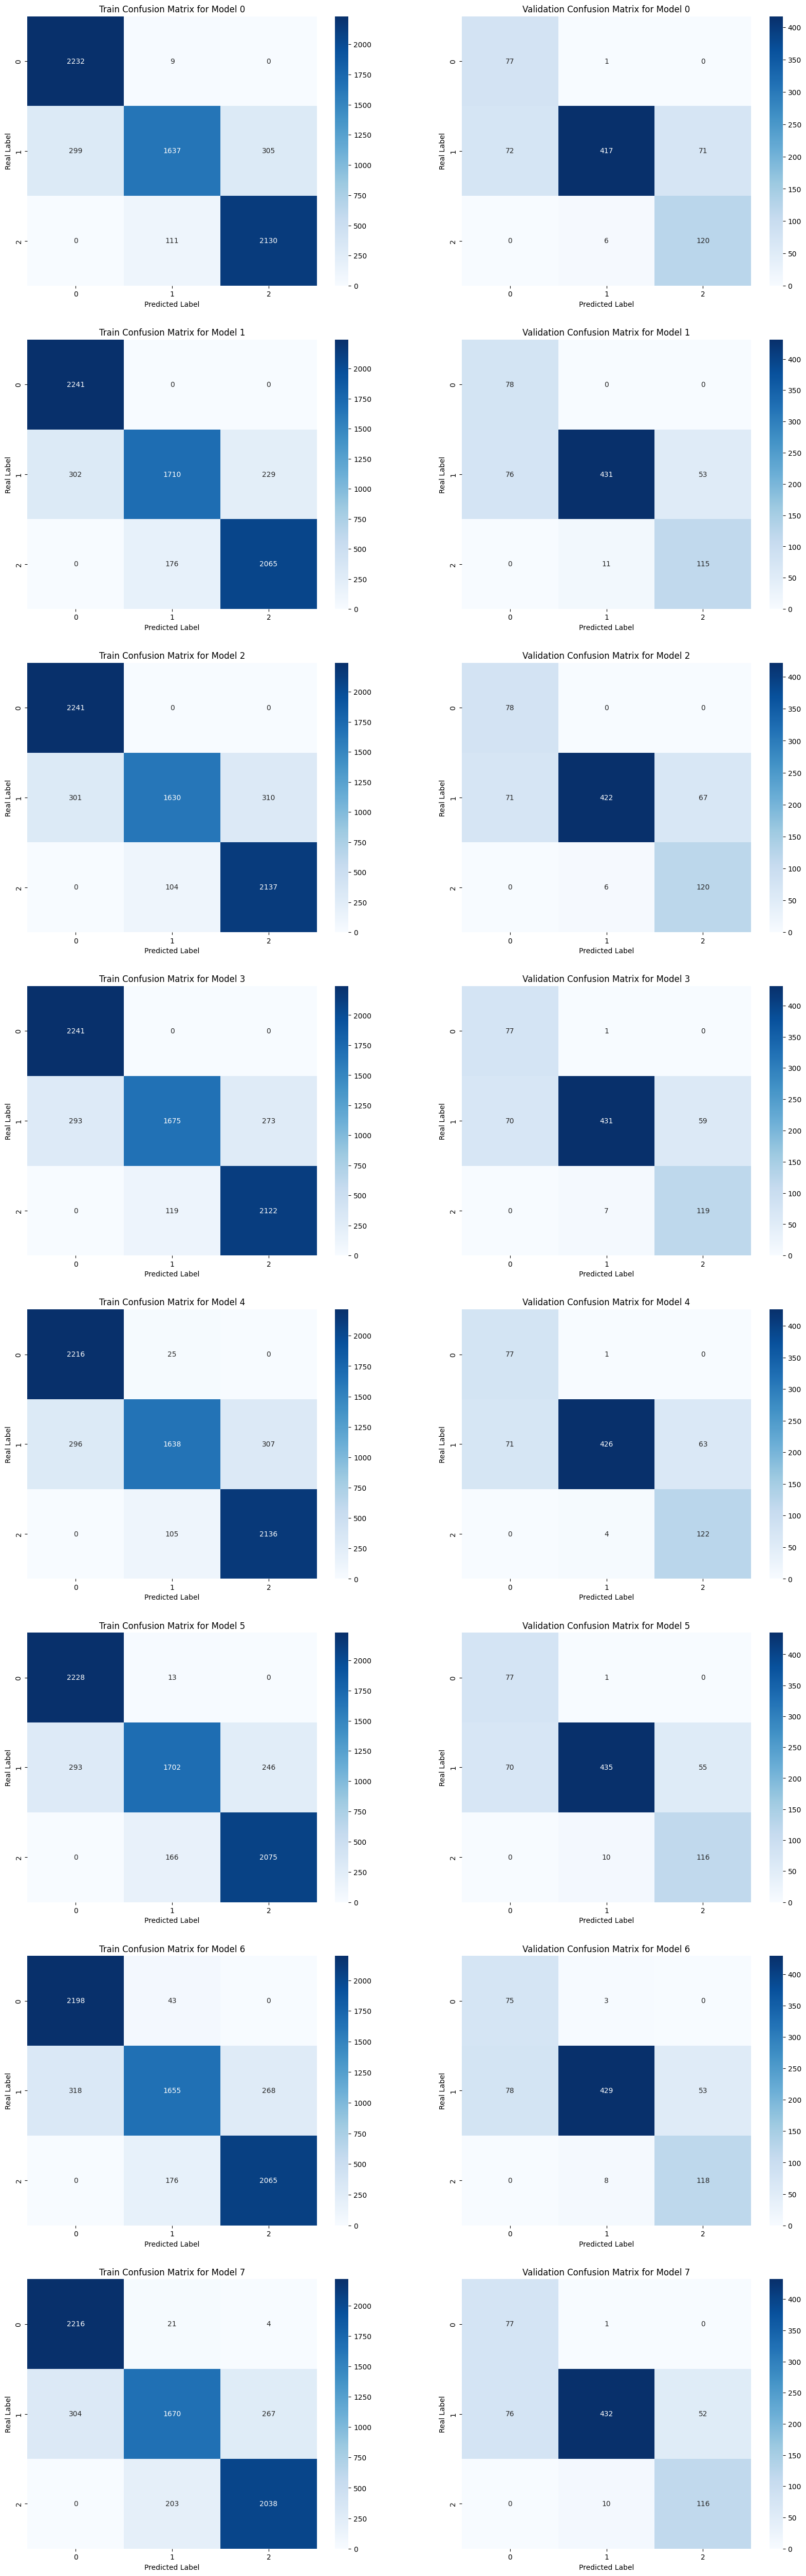

In [40]:
plot_confusion_matrices(train_confusion_matrix, val_confusion_matrix)

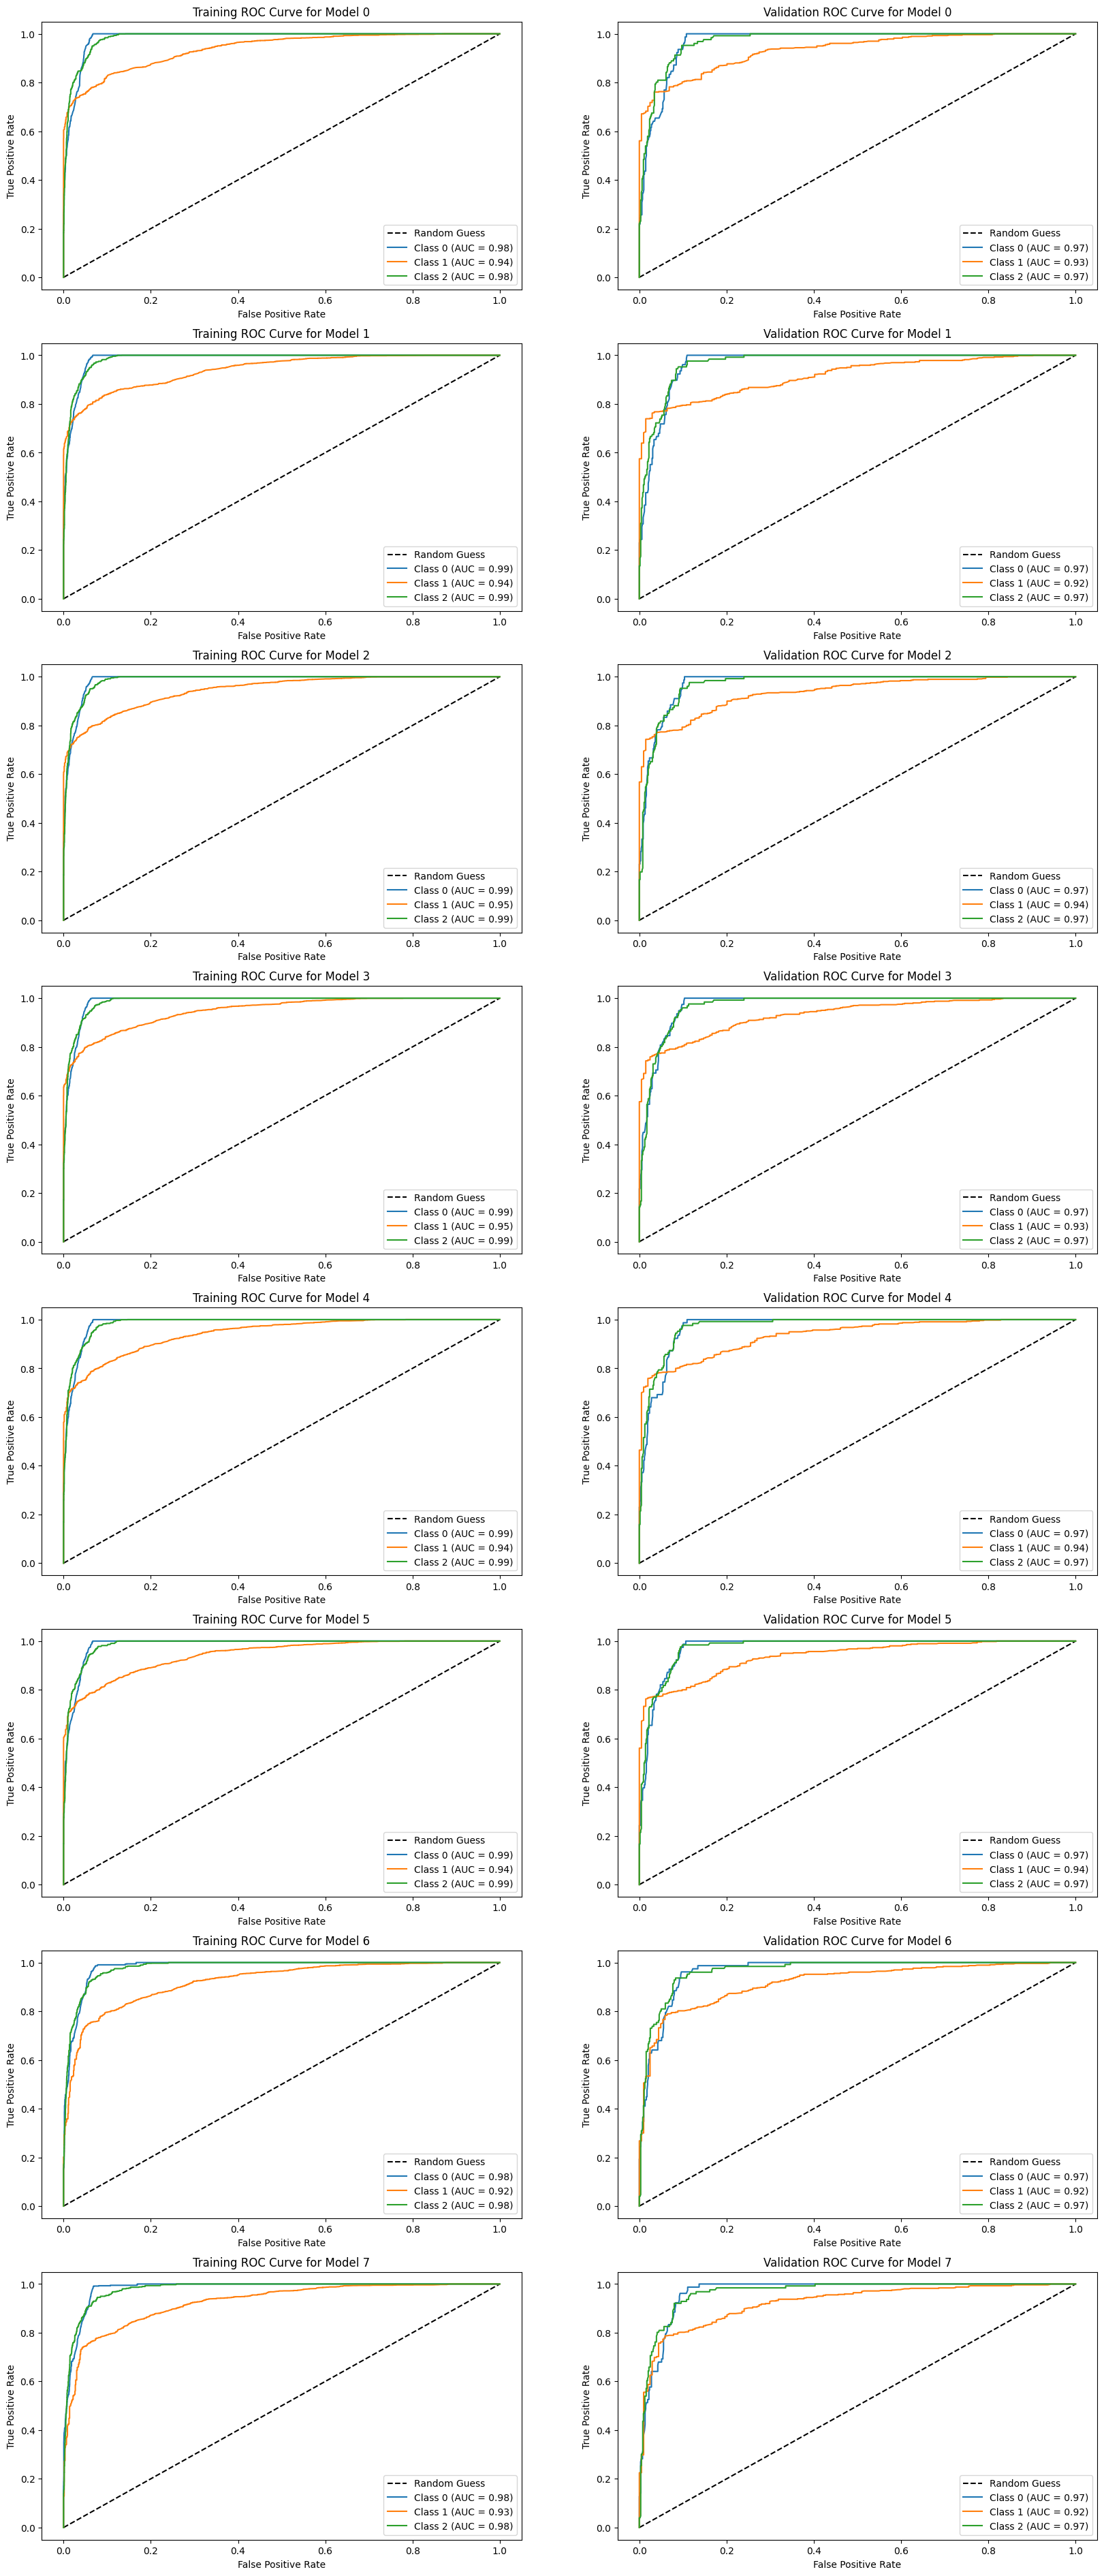

In [31]:
plot_roc_curves(train_roc_curve, val_roc_curve)

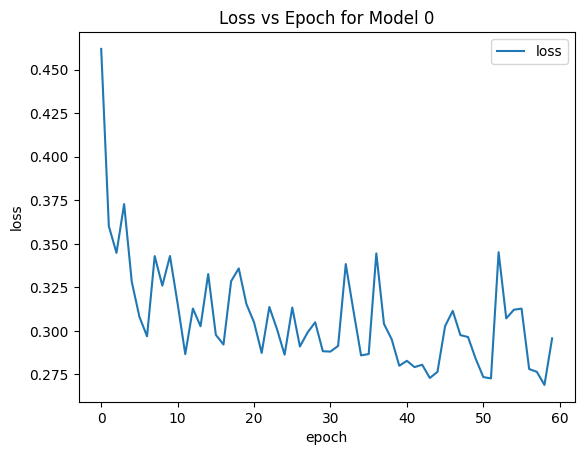

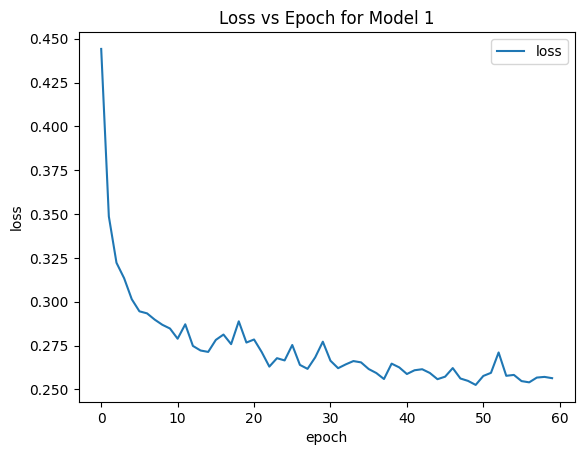

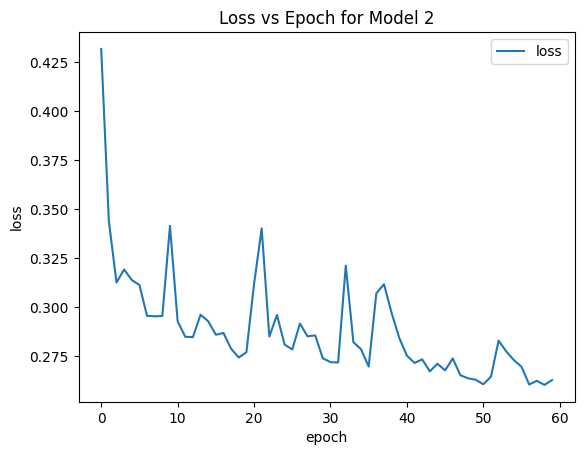

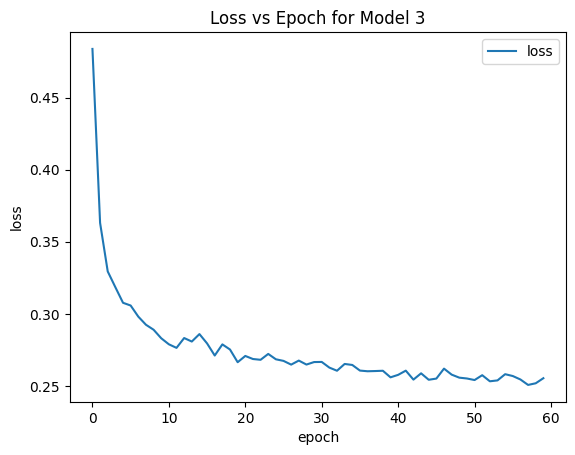

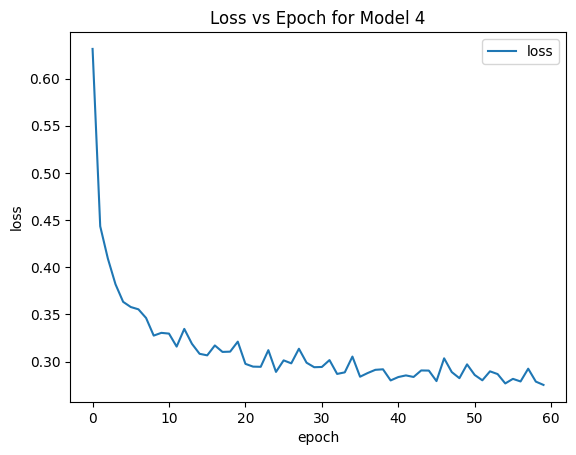

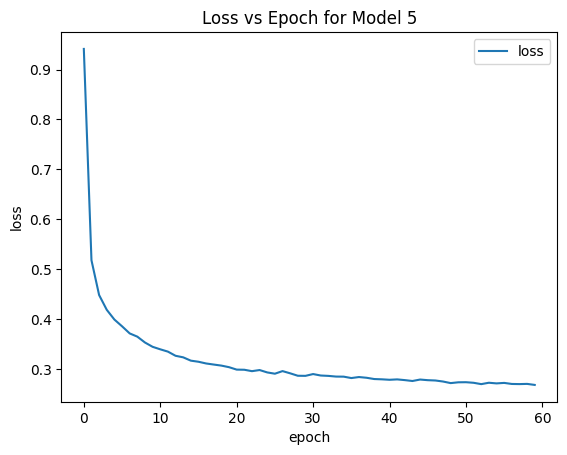

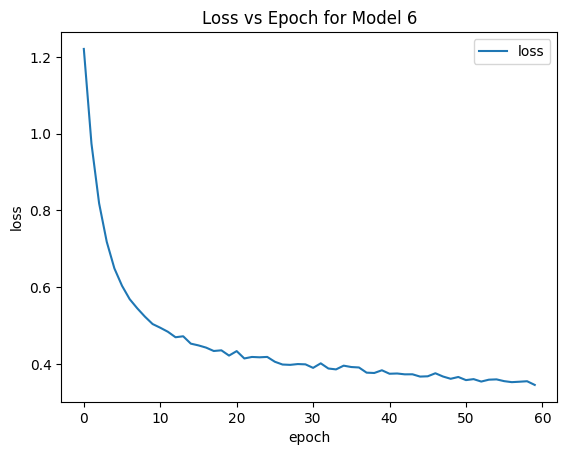

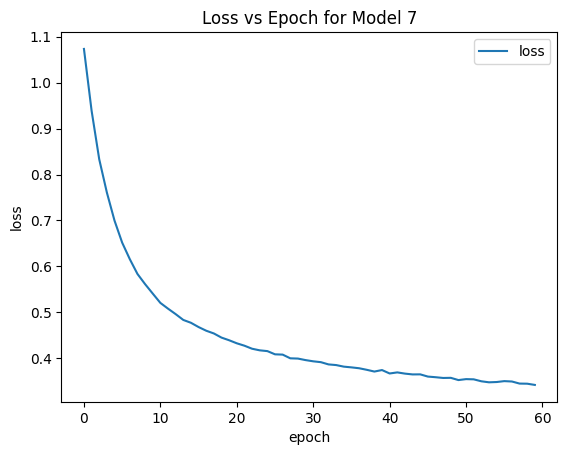

In [32]:
plot_losses(losses)

We notice that high learning rates make training very unstable.

In [33]:
val_y_preds = predict(final_model, val_x)
print(classification_report(val_y, val_y_preds))

              precision    recall  f1-score   support

           0       0.52      0.99      0.68        78
           1       0.99      0.76      0.86       560
           2       0.66      0.97      0.78       126

    accuracy                           0.82       764
   macro avg       0.72      0.91      0.78       764
weighted avg       0.89      0.82      0.83       764



# Predict on test data

In [34]:
df_test = pd.read_csv("test_data.csv")
test_x = preprocessing.preprocess(df_test, numeric_columns, ordinal_columns, nominal_columns, y=pd.Series(), oversample=False, undersample=False, random_state=42, echo_ordinal_counts=False)

In [ ]:
test_preds = predict(final_model, test_x)
np.savetxt("pred.csv", test_preds, delimiter=",", fmt='%d')

In [41]:
assert len(test_preds) == len(df_test)

# Conclusions
- When we use different methods of reducing the class imbalance general accuracy slightly suffers.
- When one class heavily dominates the dataset, accuracy may be mislaeding. Recall is the most important metric if we focus on per-class average accuracy.
- High learning rates make training very unstable.
- Oversampling, undersampling and loss weighting do well to balance the model performance on unbalanced dataset.
- Making a model deeper doesn't always improve performance. The same goes for adding dropout.
